<a href="https://colab.research.google.com/github/Ed-Cheng/Potential-Stock-Finder/blob/main/Stock_Analysis_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and initialize functions



In [1]:
pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.5 MB/s eta 0:00:00


In [2]:
from datetime import datetime, date, timedelta
import io
import math
import matplotlib.pyplot as plt
import matplotlib.image  as m_img
import numpy as np
import pandas as pd
from pandas_datareader import data
from tqdm import tqdm

import mplfinance as fplt
import yfinance as yf

In [3]:
def get_stock(target_stock: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
  """ Read the stock data """
  yf.pdr_override()
  # read and save pandas df
  df = data.get_data_yahoo([target_stock], start_date, end_date, progress=False, show_errors=False)
  # fill in missing values, if any
  df = df.interpolate()
  # df.index = pd.to_datetime(df.index)
  # df = df[["Open", "Close", "Volume"]]

  return df


def load_data(symbol_list: list, ago: datetime, tdy: datetime) -> dict:
  """ get all the stock info in the given list """
  # Store stock details for plotting
  detail_dict = {}

  for i, firm in enumerate(tqdm(symbol_list)):
    if firm and "." not in firm:
      stock = get_stock(firm, ago, tdy)
      # if data less than half of the period, issue will be raised
      if len(stock) < (tdy - ago).days/2:
        print(f"'{firm}' skipped due to insufficient data")
      else:
        add_indicator(stock)
        detail_dict[firm] = stock.copy()

  return detail_dict


def get_slope(stock_df: pd.DataFrame, day=5) -> list:
  """
  Calculates the linear regression slope over a period of days
  Note that a 10% growth over 5 days gives a slope of (1.1-1)/5=0.02
  """
  slope = [np.NaN] * (day - 1)
  x = np.vstack([np.arange(day), np.ones(day)]).T
  y = stock_df["Close"].to_numpy()

  for i in np.arange(len(stock_df) - (day - 1)):
    # Very important to normalize
    Y = y[i:i+day]/y[i]
    s, _ = np.linalg.lstsq(x, Y, rcond=None)[0]
    slope.append(s)

  return slope


def add_indicator(stock_df: pd.DataFrame) -> None:
  """
  Add indicators to the stock info dataframe
  Includes various info of:
    Price change
    Moving Average
    Volume Moving Average
    Slope
    Bollinger Bands
  """

  stock_df["InDayChg"] = 100*(stock_df["Close"] - stock_df["Open"])/stock_df["Open"]
  stock_df["PriceChg"] = 100*(stock_df["Close"] - stock_df.shift(1)["Close"])/stock_df.shift(1)["Close"]

  indicator_days = [3, 5, 10, 20]
  for days in indicator_days:
    # Price Moving Average (MA)
    stock_df[f"MA{days}"] = stock_df["Close"].rolling(days).mean()

    # Volume Moving Average (VMA)
    stock_df[f"VMA{days}"] = stock_df["Volume"].rolling(days).mean()

    # Volume Moving Average (VMA) relative to today's volume
    stock_df[f"relVMA{days}"] = stock_df["Volume"]/stock_df[f"VMA{days}"]

  stock_df["slope"] = get_slope(stock_df, 5)

  # bollinger-band
  stock_df["STD"] = stock_df["Close"].rolling(20).std()
  stock_df["STD+2"] = stock_df["MA20"] + 2*stock_df["STD"]
  stock_df["STD-2"] = stock_df["MA20"] - 2*stock_df["STD"]


def add_ranking(candidate: list, ranking: dict, screen_name: str) -> dict:
  """
  Store the result of each ticker after one analysis
  """
  for c in candidate:
    if c in ranking:
      ranking[c].append(screen_name)
    else:
      ranking[c] = [screen_name]
  return ranking



def candle_plot(stock_df: pd.DataFrame, title: str) -> None:
  """
  Plot a candle plot for one ticker
  """
  # This adds a side plot, decide where the plot goes by "panel"
  VMA5 = fplt.make_addplot(stock_df["VMA5"], color="red", width=1.5, panel=1)
  VMA10 = fplt.make_addplot(stock_df["VMA10"], color="orange", width=1.5, panel=1)
  VMA20 = fplt.make_addplot(stock_df["VMA20"], color="purple", width=1.5, panel=1)

  fplt.plot(stock_df,
            type='candle',
            addplot = [VMA5, VMA10, VMA20],
            # style='charles',
            mav=(5, 10, 20),
            mavcolors=["red", "orange", "purple"],
            xlim=(len(stock_df)-40, len(stock_df)),
            # title=title,
            ylabel=f"Price of {title}",
            volume=True,
            ylabel_lower='Volume')


# https://github.com/matplotlib/mplfinance/issues/318
def candle_plot_multi(stock_df: pd.DataFrame, title: str) -> None:
  """
  Plot two plots in one figure, one candle plot and one slope plot
  """
  sav1 = io.BytesIO()
  sav2 = io.BytesIO()

  # This adds a side plot, decide where the plot goes by "panel"
  VMA5 = fplt.make_addplot(stock_df["VMA5"], color="red", width=1.5, panel=1)
  VMA10 = fplt.make_addplot(stock_df["VMA10"], color="orange", width=1.5, panel=1)
  VMA20 = fplt.make_addplot(stock_df["VMA20"], color="purple", width=1.5, panel=1)
  upper = fplt.make_addplot(stock_df["STD+2"], color="grey", width=1, panel=0)
  lower = fplt.make_addplot(stock_df["STD-2"], color="grey", width=1, panel=0)

  # Plot 1: candle plot
  fplt.plot(stock_df,
            type='candle',
            addplot = [upper, lower, VMA5, VMA10, VMA20],
            # style='charles',
            mav=(5, 10, 20),
            mavcolors=["red", "orange", "purple"],
            xlim=(len(stock_df)-40, len(stock_df)),
            # title=title,
            ylabel=f"Price of {title}",
            volume=True,
            ylabel_lower='Volume',
            savefig=sav1)

  # Plot 2: slope plot
  fig, ax = plt.subplots(figsize=(4,2))
  ax.bar(np.arange(-14, 1), stock_df['slope'][-15:])
  ax.set_title('Price-trend momentum')
  ax.set_ylabel('Slope')
  ax.set_xlabel('Past x days')
  ax.set_yticks(np.arange(-0.02, 0.1, 0.02))
  plt.savefig(sav2, bbox_inches='tight')
  plt.close()

  # Rewind the files:
  _ = sav1.seek(0)
  _ = sav2.seek(0)

  # Read the files as images:
  img1 = m_img.imread(sav1)
  img2 = m_img.imread(sav2)

  # Create side-by-side Axes:
  fig = plt.figure(figsize=(12, 6))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)

  # Turn the axis lines and labels off since the images will already contain them
  ax1.set_axis_off()
  ax2.set_axis_off()

  # Plot each image on a separate axes:
  ax1.imshow(img1)
  ax2.imshow(img2)
  plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.0, hspace=0)
  plt.show()


def display_analysis(tickers: list, target_dict: dict, info_dict: dict) -> None:
  """ Iterate through all the tickers and display the candel plot and slope plot"""
  for t in tickers:
    if t in info_dict:
      print(f"{t}, {info_dict[t]}")
    else:
      print(f"{t}")
    candle_plot_multi(target_dict[t], t)

## Webscrape the ticker list (Index, Russell, S&P500...)


In [4]:
# sp500_table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
# sp500_list = list(sp500_table[0]["Symbol"])

russell_table = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")
russell_list = list(russell_table[2]["Ticker"])

detail_dict = {key: val for key, val in zip(russell_table[2]["Ticker"], russell_table[2]["GICS Sector"])}


## Load personal ticker list from google drive (If applicable)
Comment this section out if don't have a personal list

In [5]:
# Personal tickers
excel_path = "/content/drive/MyDrive/Colab Notebooks/2023-03 Trading/us_stock.xlsx"
my_df = pd.read_excel(excel_path)

## Check the date for analysis
Check if market is open; the time zone may be different, etc

In [6]:
tdy = datetime.now()
# Include a day more to deal with time zone issue
tdy = datetime.now() + timedelta(days=1)
# tdy = datetime.now() - timedelta(days=1)

# Quarter of a year (3 months)
qtr = 90
ago = datetime.now() - timedelta(days=qtr)
print(tdy)

2023-06-22 11:42:18.554487


## Load symbols in the list

In [7]:
# tickers from webscraped list
russell = load_data(russell_list, ago, tdy)

 37%|███▋      | 372/1006 [01:50<02:42,  3.90it/s]

'FISV' skipped due to insufficient data


 66%|██████▌   | 666/1006 [03:18<01:25,  3.96it/s]

'OSH' skipped due to insufficient data


100%|██████████| 1006/1006 [05:01<00:00,  3.34it/s]


In [8]:
# My personal lists
mylist = load_data(list(my_df["ticker"]), ago, tdy)

meme = {x:mylist[x] for x in list(my_df.loc[my_df.level.isin(["meme"])]["ticker"])}
focus = {x:mylist[x] for x in list(my_df.loc[my_df.level.isin(["focus"])]["ticker"])}
hold = {x:mylist[x] for x in list(my_df.loc[my_df.holding == True]["ticker"])}


100%|██████████| 69/69 [00:13<00:00,  5.21it/s]


# Quick Check "focus" & "meme" tickers
- Quick overview of personally selected stocks

AMZN, Consumer Discretionary


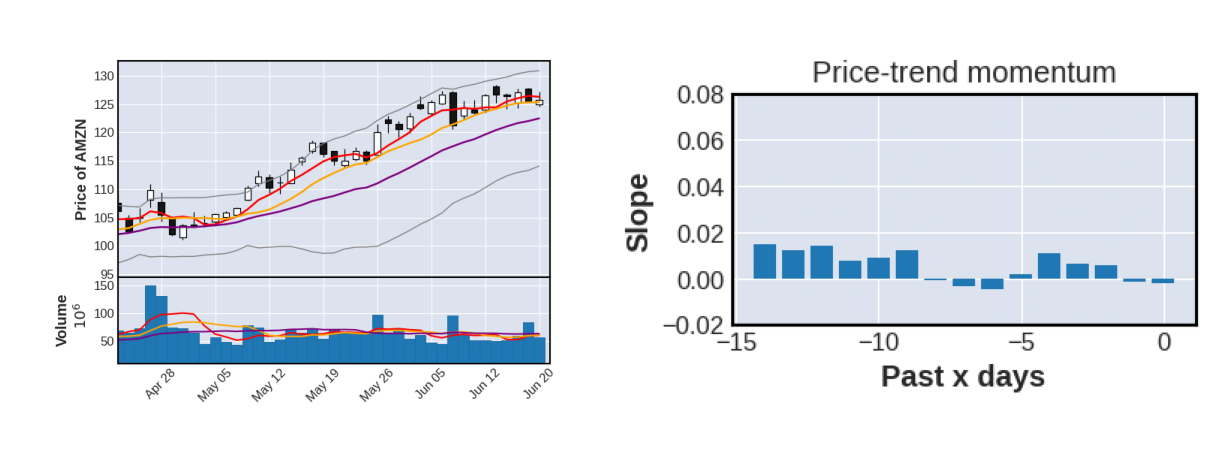

BAC, Financials


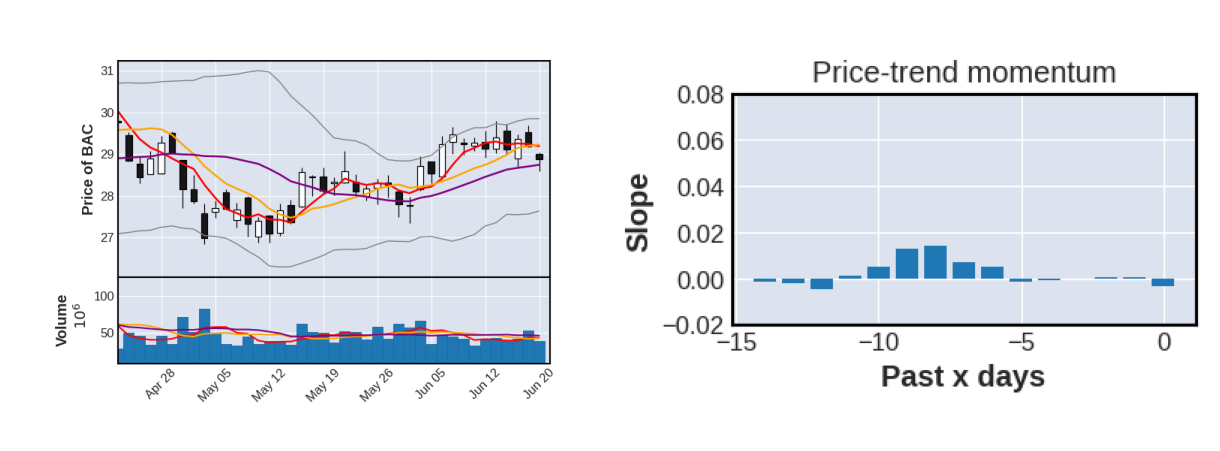

META, Communication Services


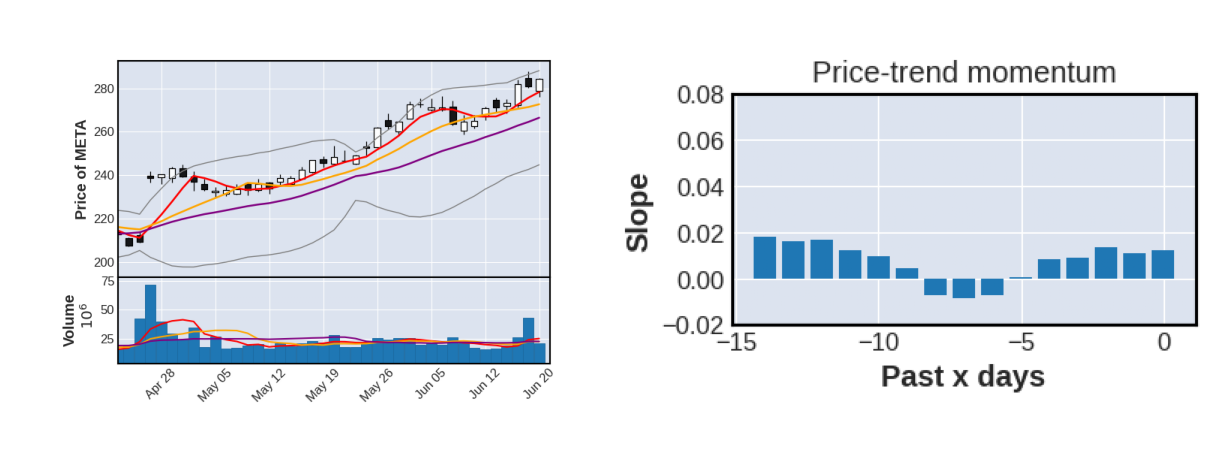

NVDA, Information Technology


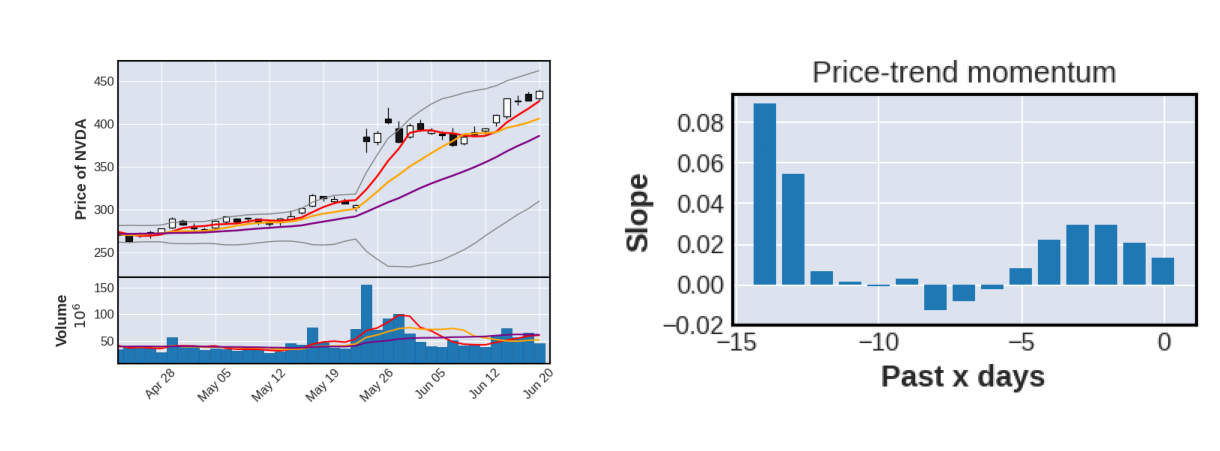

ON, Information Technology


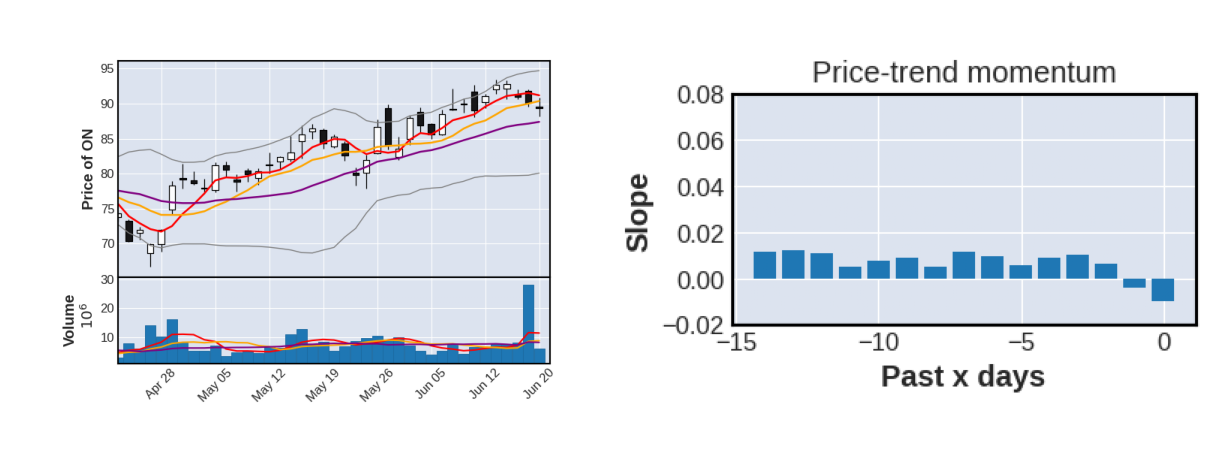

In [9]:
# For demo purpuse, only show 5
display_analysis(list(focus.keys())[:5], focus, detail_dict)

AI


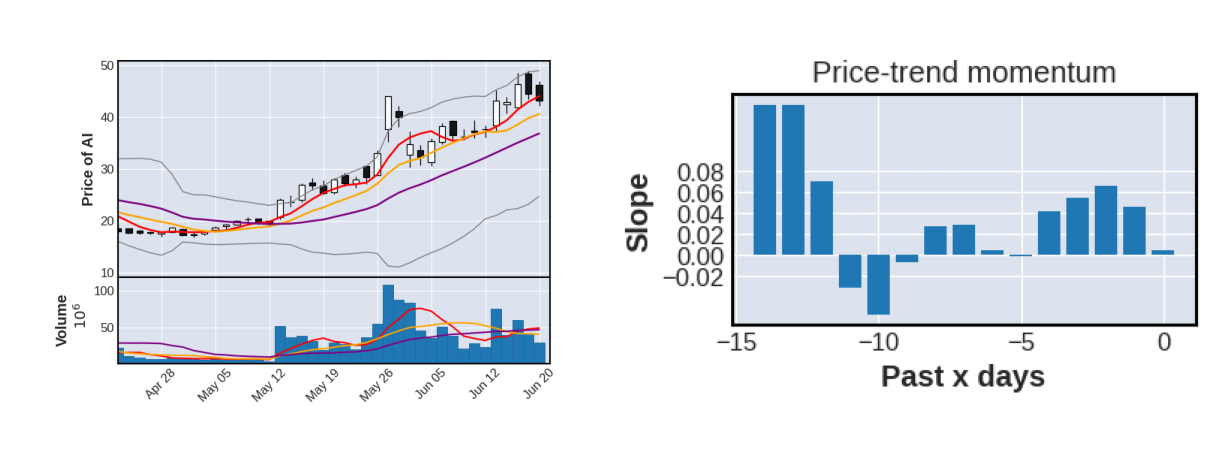

PLTR, Information Technology


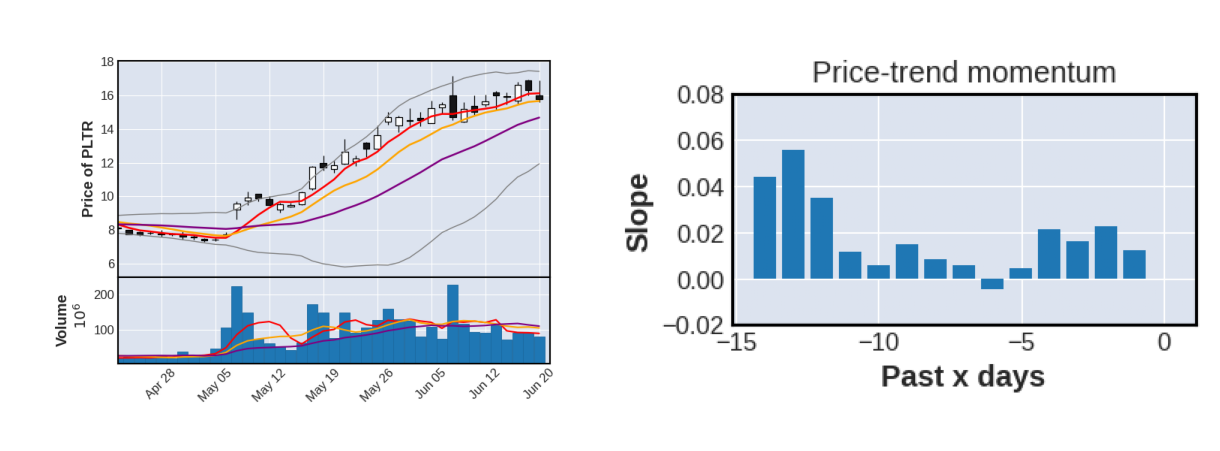

SNOW, Information Technology


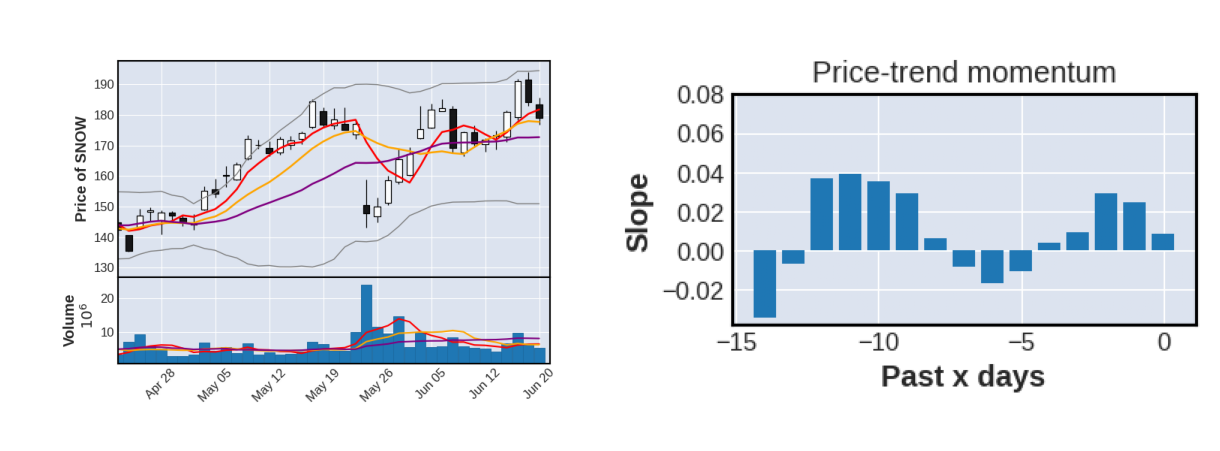

U, Information Technology


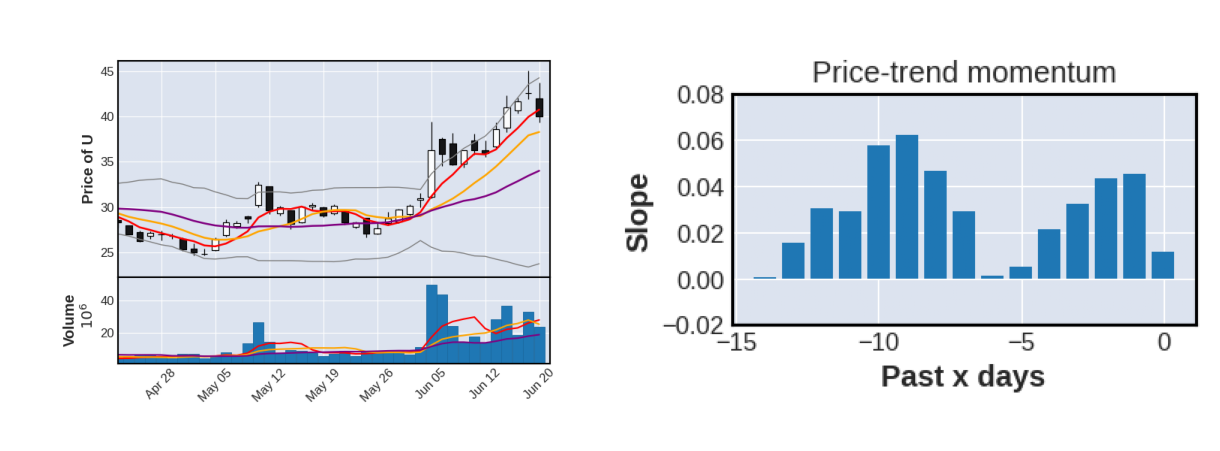

UPST, Financials


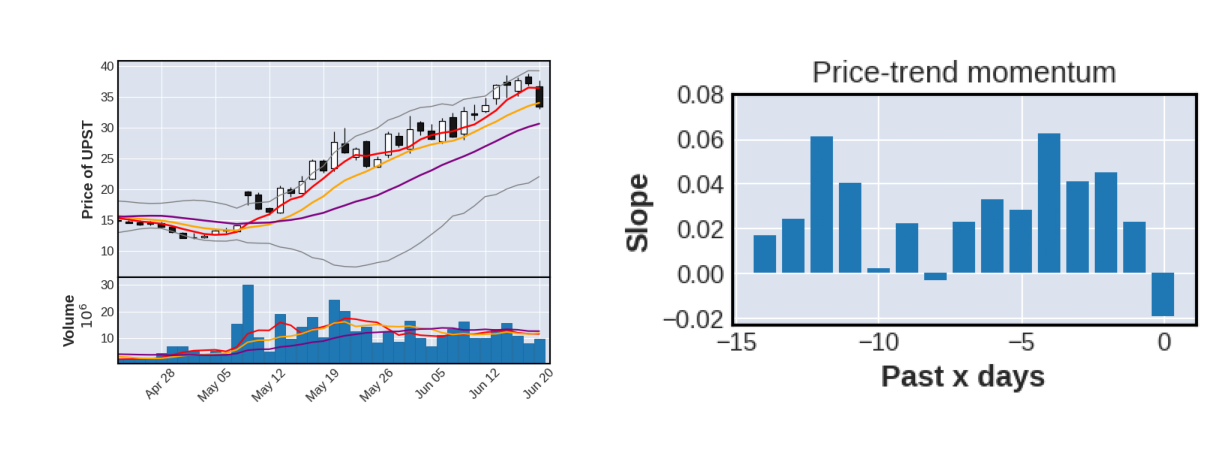

In [10]:
# For demo purpuse, only show 5
display_analysis(list(meme.keys())[:5], meme, detail_dict)

# Start analysis

In [11]:
# The dictionary that will be used to store all the ranking info below
final_ranking = dict()

## High potential: Extreme volume with high changes
- Stock that attracted a lot of investors in a short time. Have high potential.

In [12]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = russell

volume = {5: [],
          10: [],
          20: []}

threshold = 1.5

for k in chosen_data.keys():
  if chosen_data[k].iloc[-1]["InDayChg"] > 3:
    # Duplicates are acceptable in this section
    if chosen_data[k].iloc[-1]["relVMA20"] > threshold:
      volume[20].append(k)
    if chosen_data[k].iloc[-1]["relVMA10"] > threshold:
      volume[10].append(k)
    if chosen_data[k].iloc[-1]["relVMA5"] > threshold:
      volume[5].append(k)

print(len(volume[5]), len(volume[10]), len(volume[20]))

3 5 4


In [13]:
final_ranking = add_ranking(list(set(volume[5] + volume[10])), final_ranking, "volume")

ALGM, Information Technology


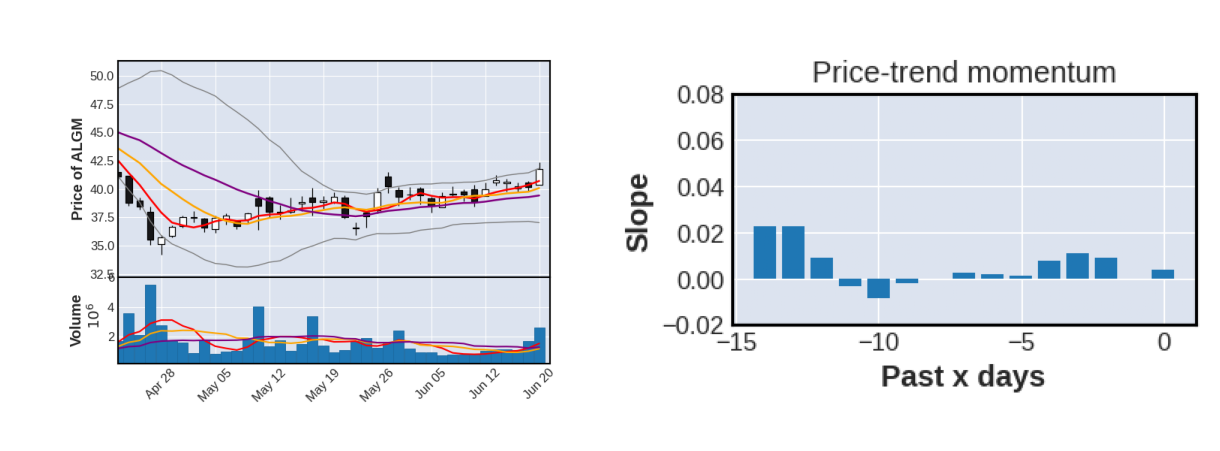

GNRC, Industrials


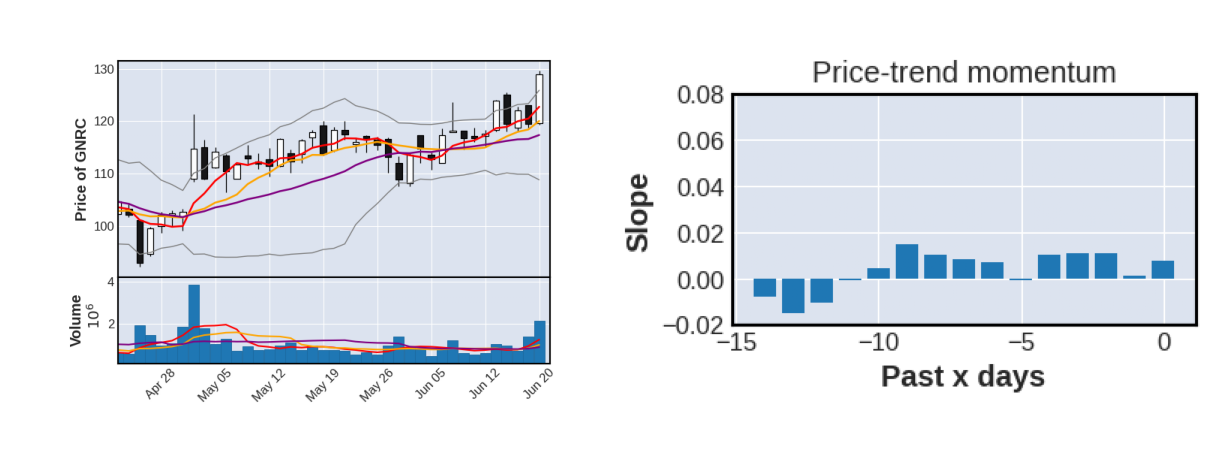

CAR, Industrials


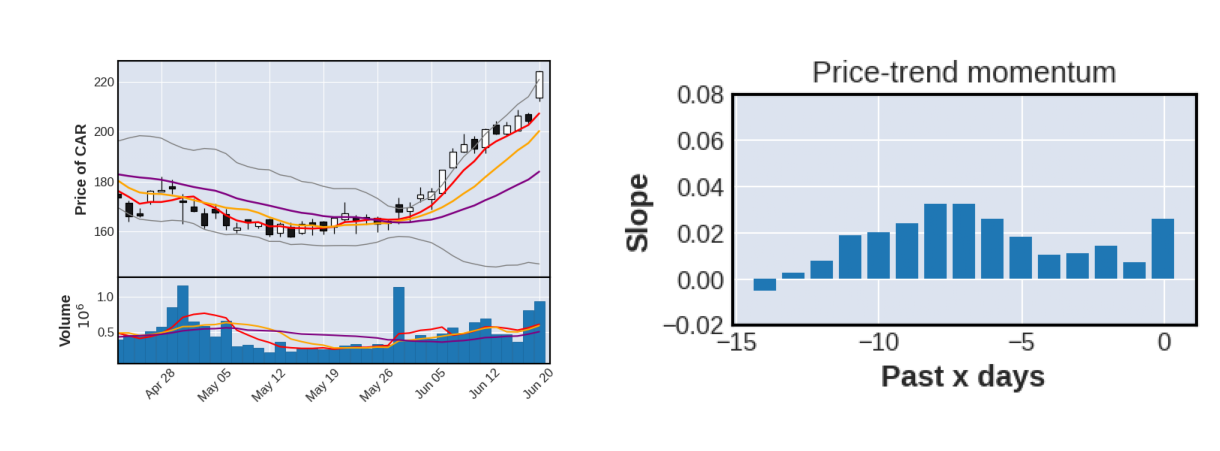

KMPR, Financials


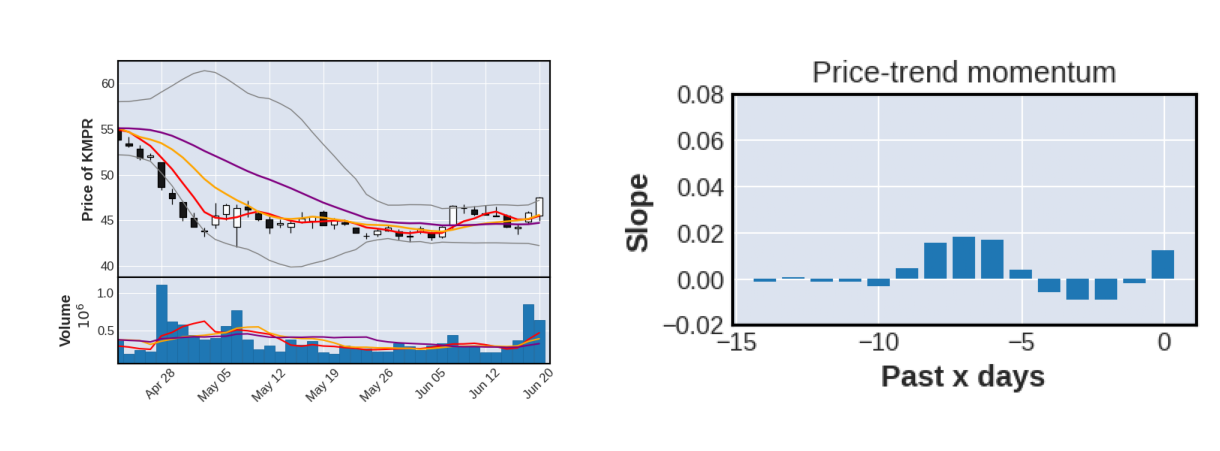

DHR, Health Care


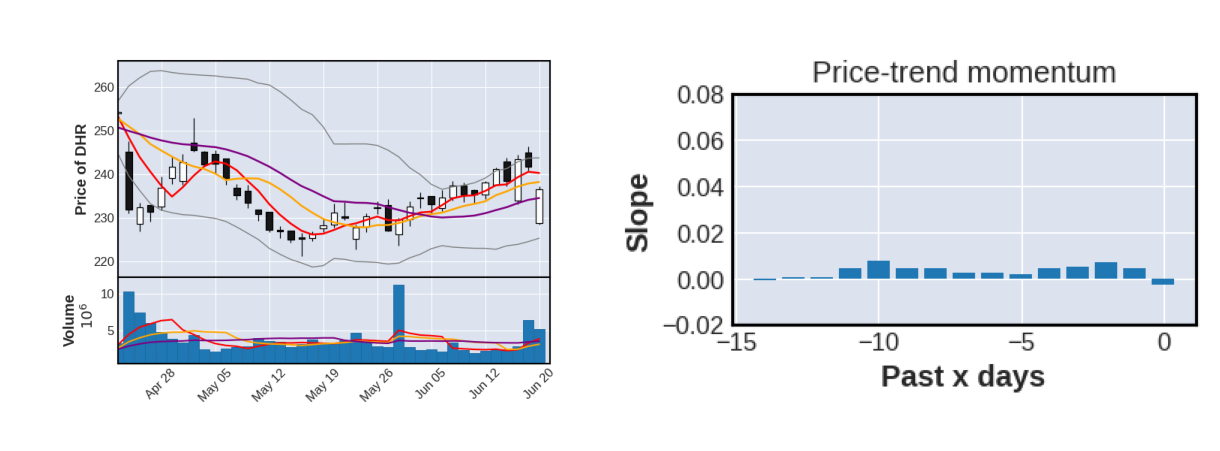

In [14]:
# For demo purpuse, only show 5
display_analysis(list(set(volume[5] + volume[10]))[:5], chosen_data, detail_dict)

## High potential: 10ma continuously growing
- Use this on full ticker lists to look for potential stocks (russell, s&p500...)
- Very strict constraint, stocks shown here have high potential


In [15]:
chosen_data = russell

growth = {3: [],
          5: []}

for k in chosen_data.keys():
  diff = np.array(chosen_data[k][-19:]["MA10"]) - np.array(chosen_data[k][-20:-1]["MA10"])

  if not np.any(diff < 0):
    # Save in order so there won't be duplicates
    if (diff[-5:] == sorted(diff[-5:])).all():
      growth[5].append(k)
    elif (diff[-3:] == sorted(diff[-3:])).all():
      growth[3].append(k)

print(len(growth[3]), len(growth[5]))

5 1


In [16]:
final_ranking = add_ranking(growth[3] + growth[5], final_ranking, "10ma up")

MKSI, Information Technology


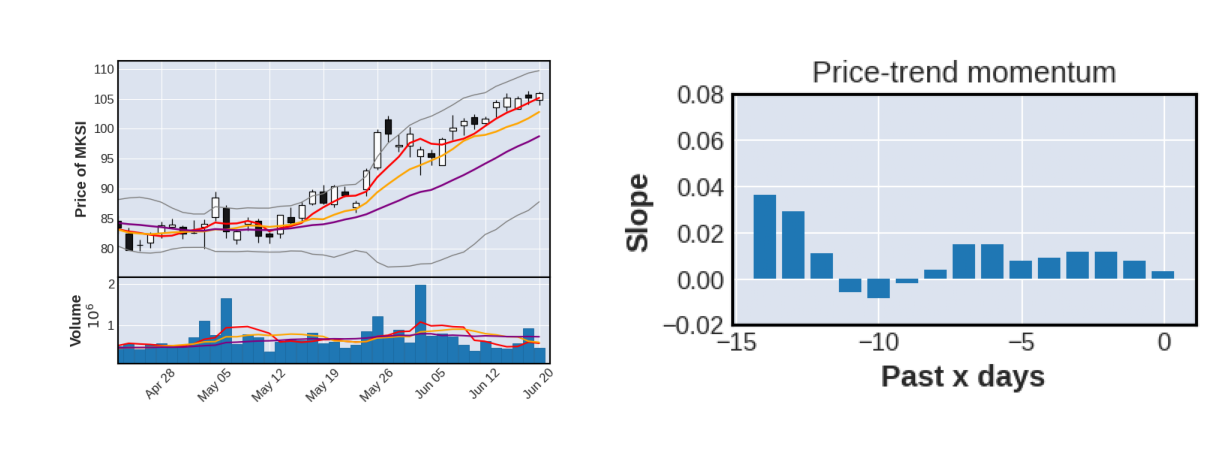

NVDA, Information Technology


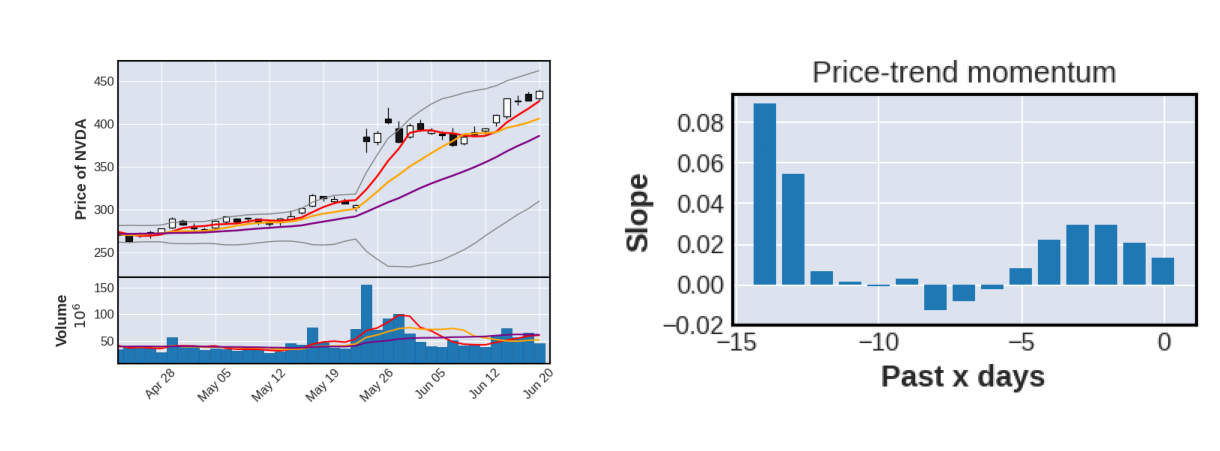

QRVO, Information Technology


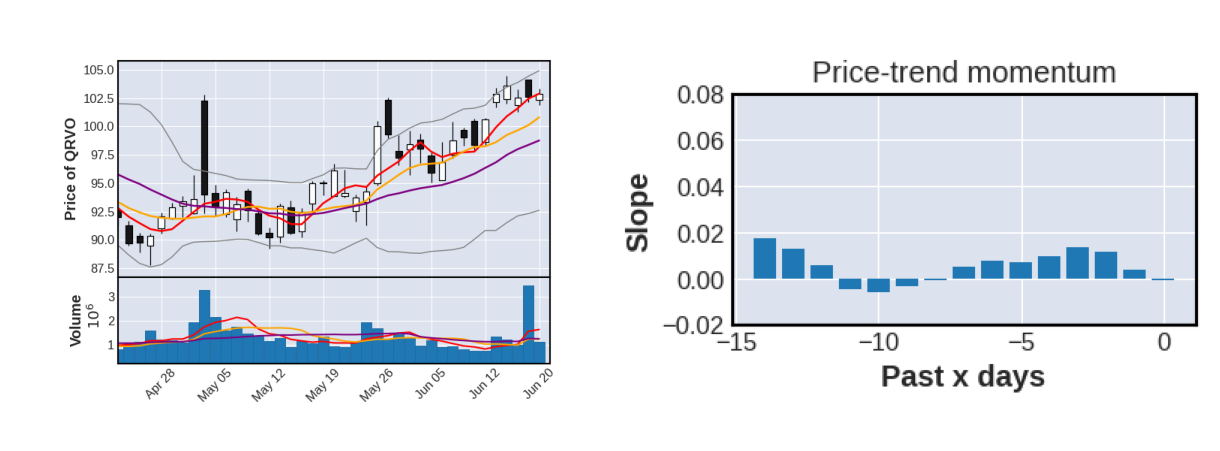

SWKS, Information Technology


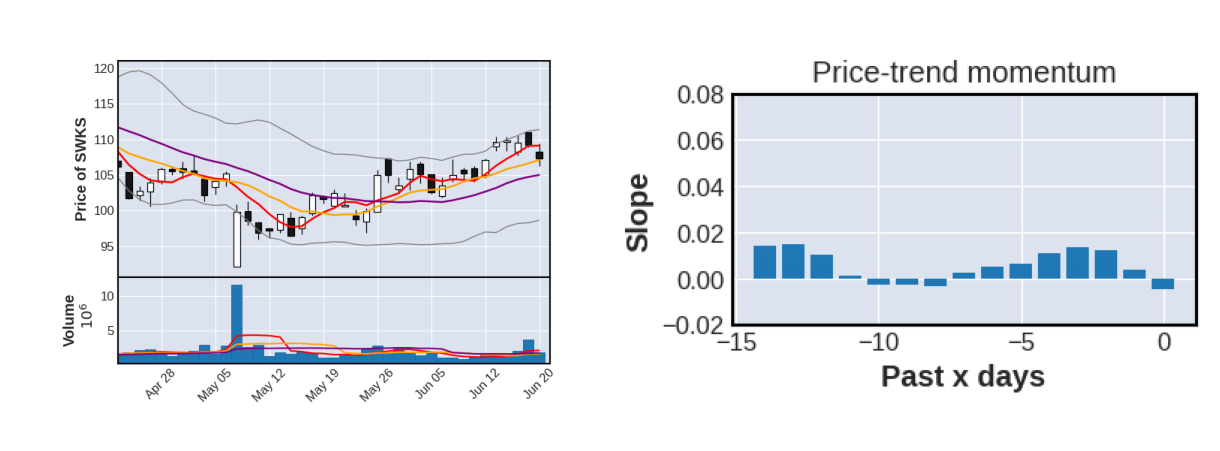

UNVR, Industrials


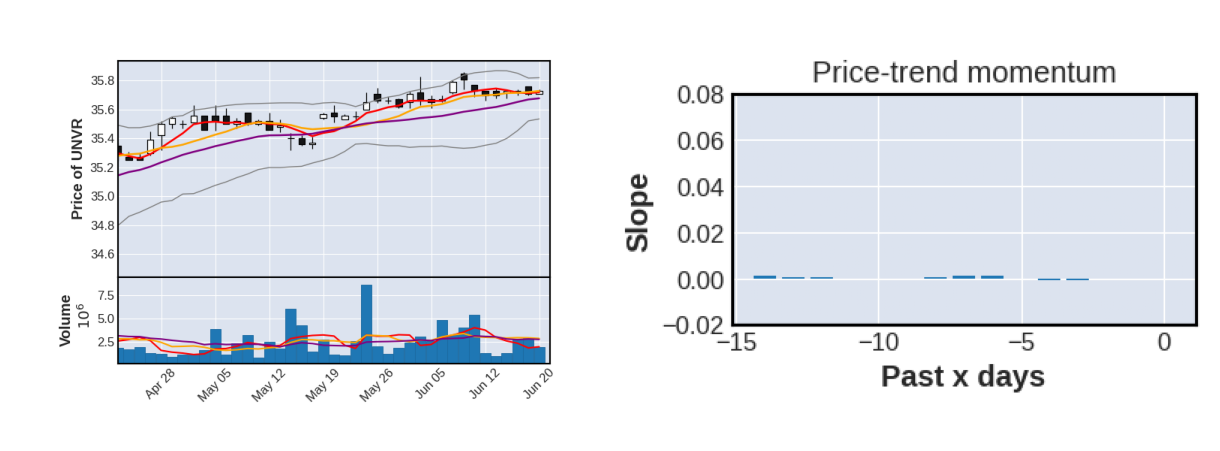

In [17]:
# For demo purpuse, only show 5
display_analysis((growth[3] + growth[5])[:5], chosen_data, detail_dict)

## High potential: Slope continuously growing
- Depends on the given slope. A slope of 0.02 is quite a strict requirement.


In [18]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = russell

slope = {3: [],
         5: [],
         10: [],
         15: []}

for k in chosen_data.keys():
  slp = np.where(chosen_data[k][-20:]["slope"] > 0.0125, 1, 0)

  # Save in order so there won't be duplicates
  if sum(slp[-15:]) == 15:
    slope[15].append(k)
  elif sum(slp[-10:]) == 10:
    slope[10].append(k)
  elif sum(slp[-5:]) == 5:
    slope[5].append(k)
  elif sum(slp[-3:]) == 3:
    slope[3].append(k)

print(len(slope[3]), len(slope[5]), len(slope[10]), len(slope[15]))

13 5 0 0


In [19]:
final_ranking = add_ranking(slope[3] + slope[5] + slope[10] + slope[15], final_ranking, "slope")

BSX, Health Care


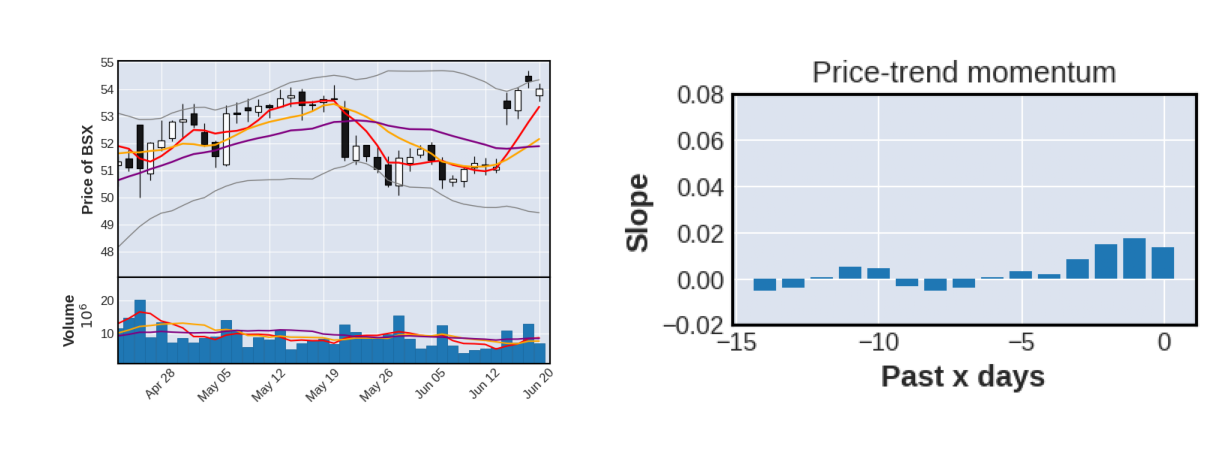

CC, Materials


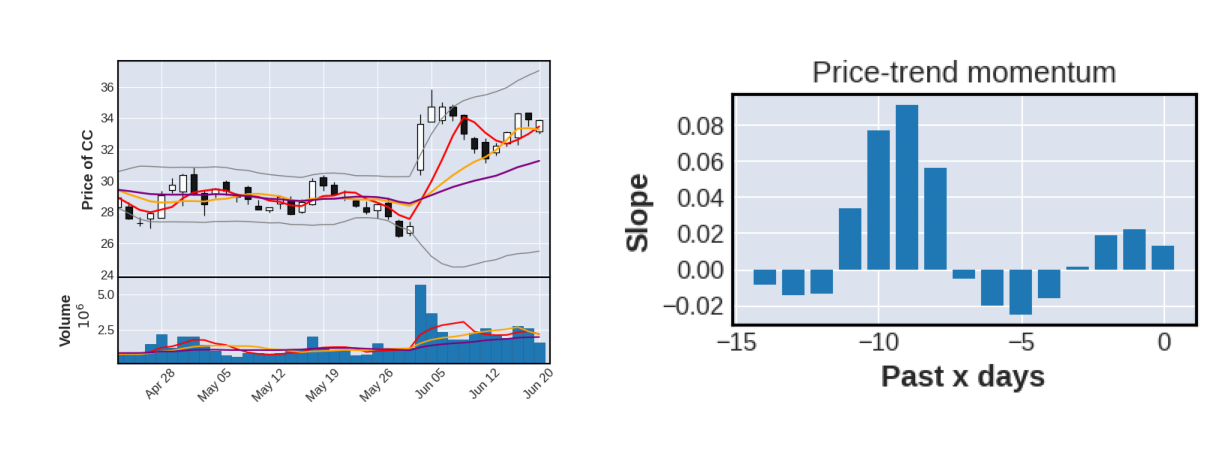

DPZ, Consumer Discretionary


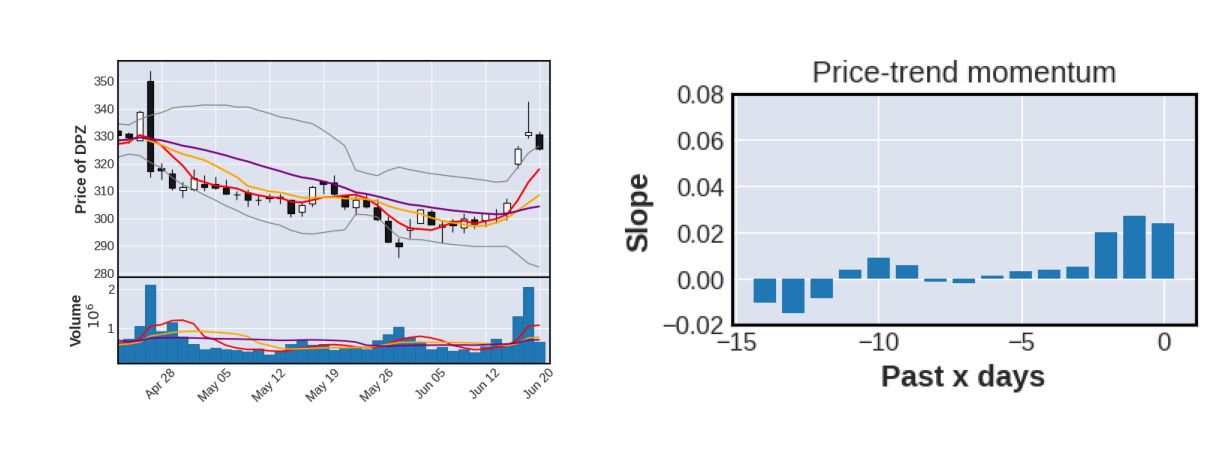

EL, Consumer Staples


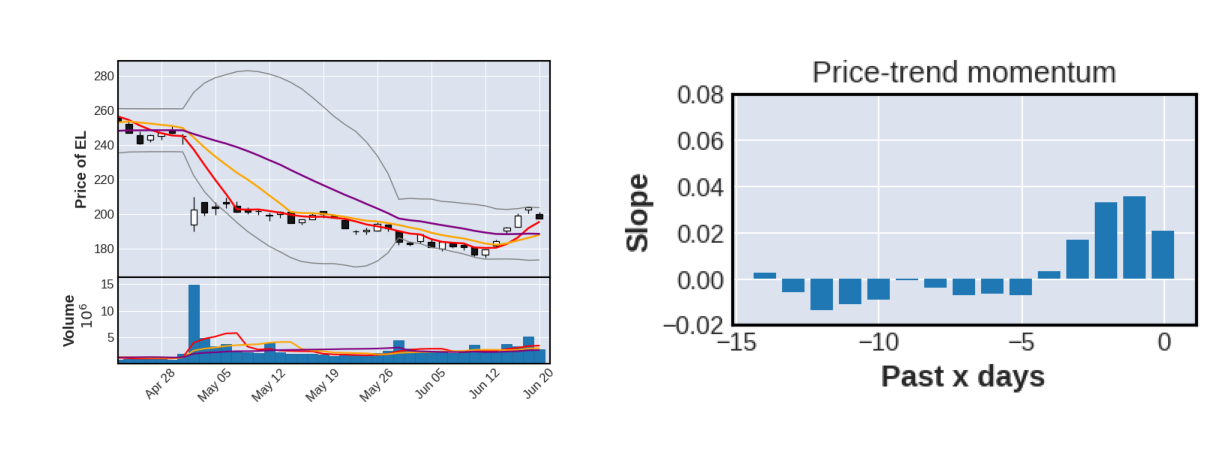

IPGP, Information Technology


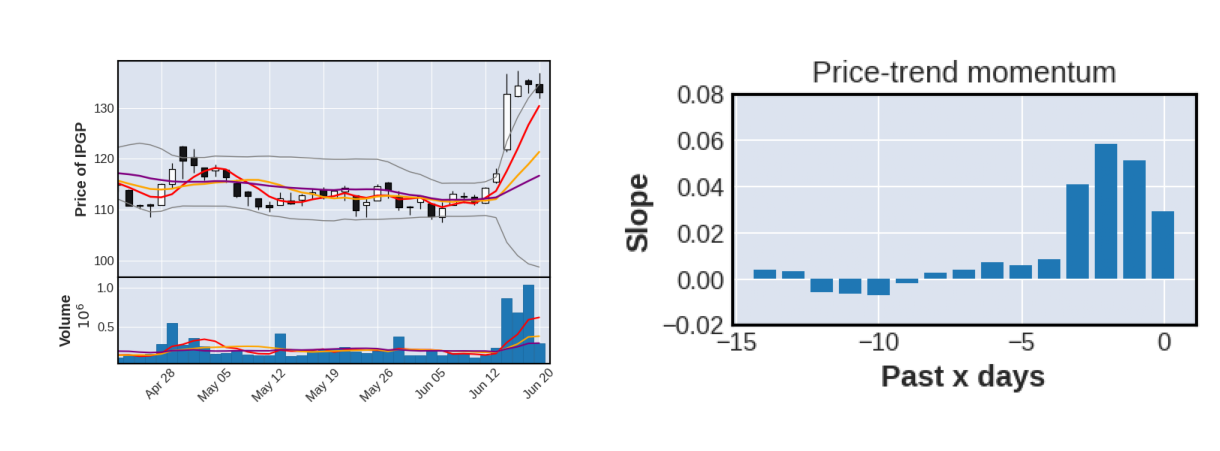

In [20]:
# For demo purpuse, only show 5
display_analysis((slope[3] + slope[5])[:5], chosen_data, detail_dict)

## Mid potential: Close price > 5ma over certain days
- Use this on full ticker lists to look for potential stocks (russell, s&p500...)
- Not a strict constraint, may show a lot of stock that needs further inspection

In [21]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = russell

ma_5 = {5: [],
        10: [],
        15: []}

for k in chosen_data.keys():
  momentum = np.where(chosen_data[k][-20:]["Close"] > chosen_data[k][-20:]["MA5"], 1, 0)

  # Save in order so there won't be duplicates
  if sum(momentum[-15:]) == 15:
    ma_5[15].append(k)
  elif sum(momentum[-10:]) == 10:
    ma_5[10].append(k)
  elif sum(momentum[-5:]) == 5:
    ma_5[5].append(k)

print(len(ma_5[5]), len(ma_5[10]), len(ma_5[15]))

116 64 9


In [22]:
final_ranking = add_ranking(ma_5[5] + ma_5[10] + ma_5[15], final_ranking, ">5ma")

OWL, Financials


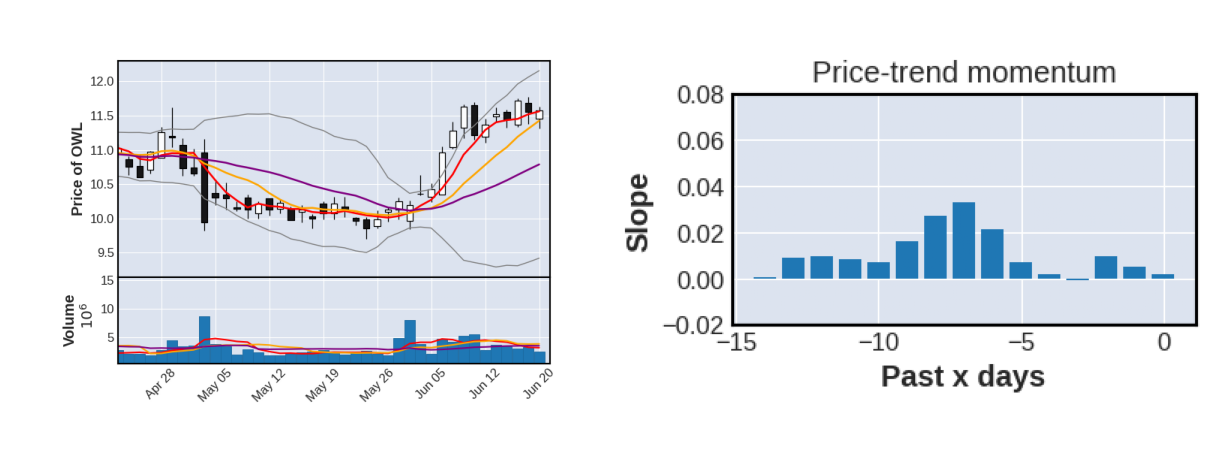

BAH, Industrials


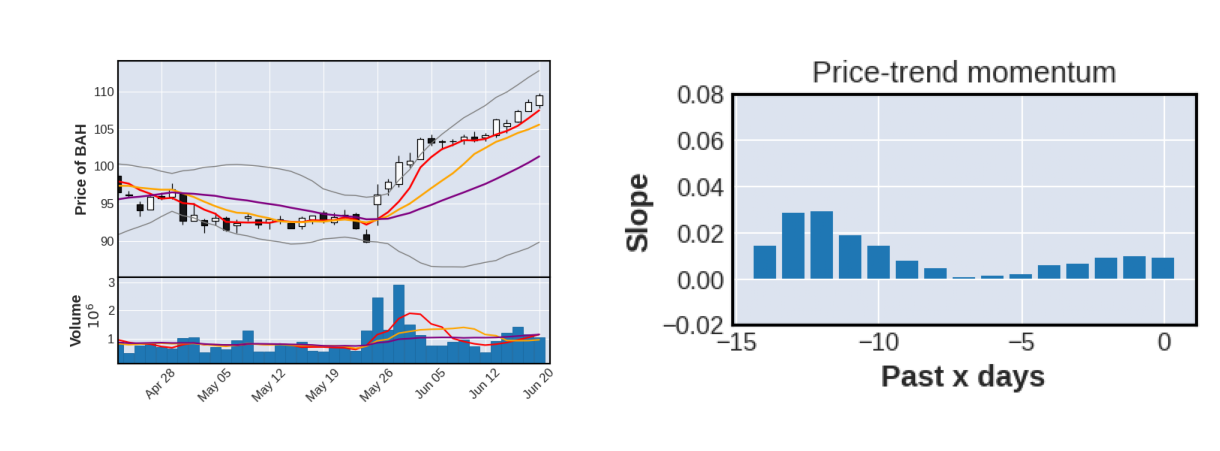

CACI, Industrials


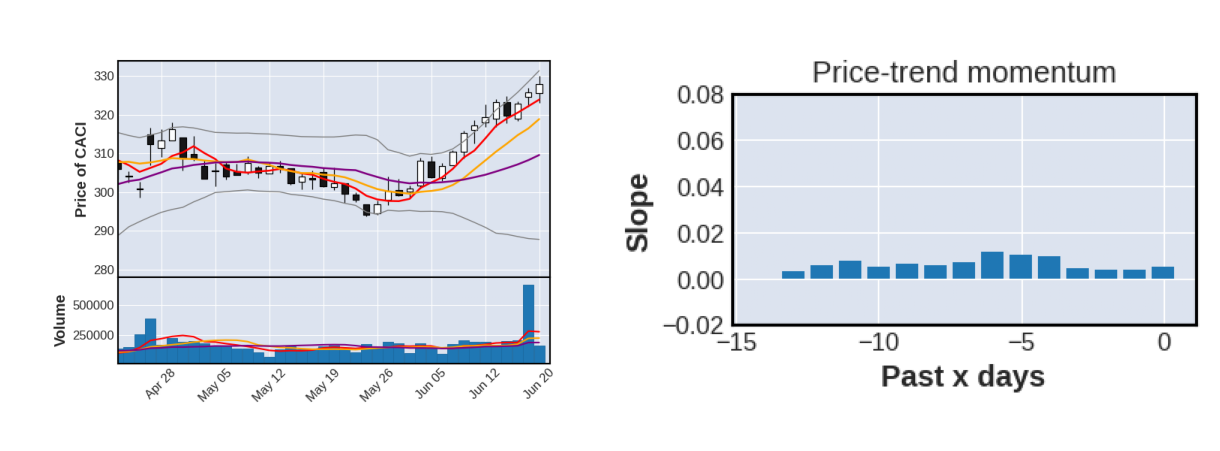

CCL, Consumer Discretionary


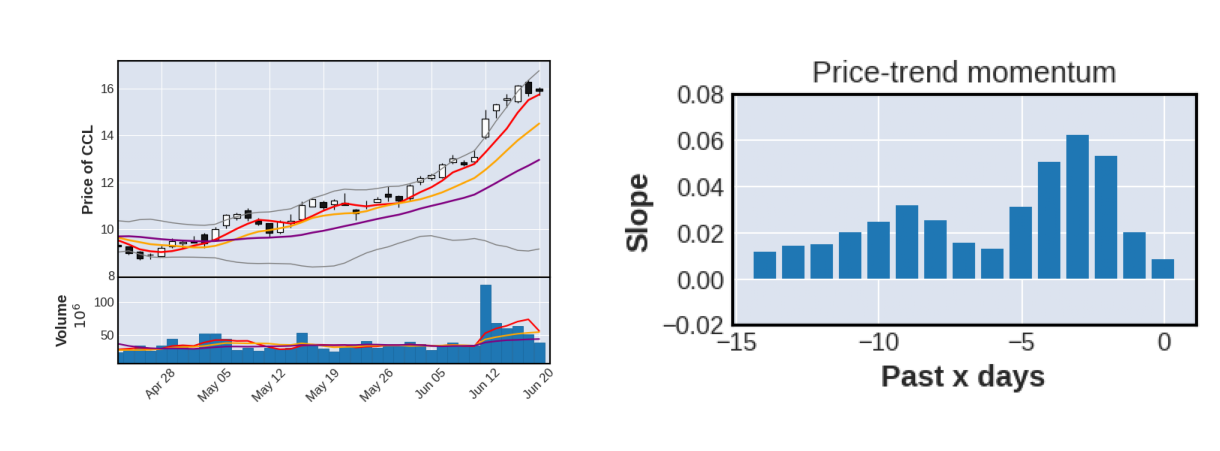

DAL, Industrials


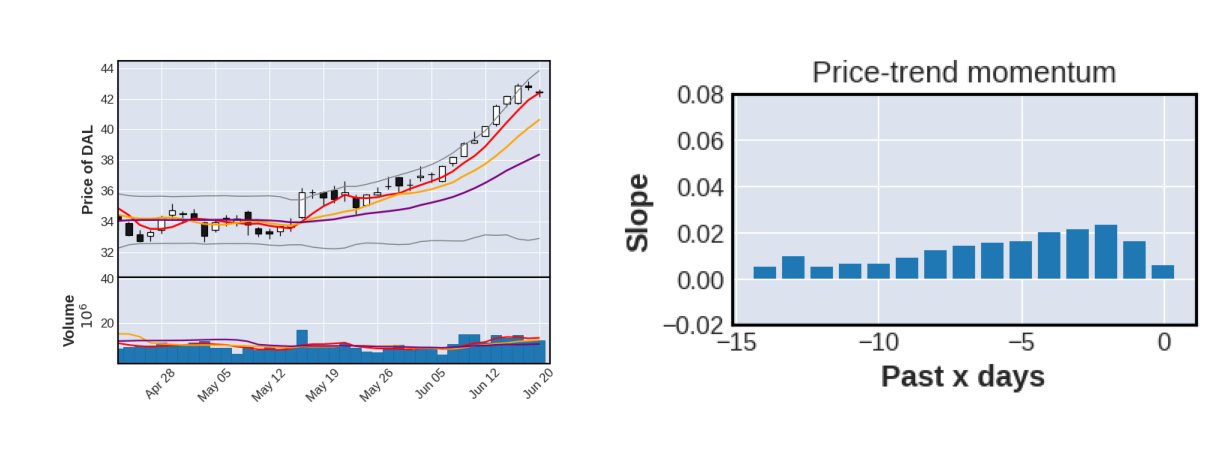

In [23]:
# For demo purpuse, only show 5
display_analysis(ma_5[15][:5], chosen_data, detail_dict)

## Mid potential: 5ma > 10ma > 20ma over certain days
- A typical bullish trend

In [24]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = russell

ma_all = {5: [],
          10: [],
          15: []}

for k in chosen_data.keys():
  momentum = np.where(chosen_data[k][-20:]["MA5"] > chosen_data[k][-20:]["MA10"], 1, 0)
  momentum = np.where(chosen_data[k][-20:]["MA10"] > chosen_data[k][-20:]["MA20"], momentum, 0)

  # Limit price to below 400k
  if chosen_data[k].iloc[-1]["Close"] < 400:
    # Save in order so there won't be duplicates
    if sum(momentum[-15:]) == 15:
      ma_all[15].append(k)
    elif sum(momentum[-10:]) == 10:
      ma_all[10].append(k)
    elif sum(momentum[-5:]) == 5:
      ma_all[5].append(k)

print(len(ma_all[5]), len(ma_all[10]), len(ma_all[15]))

246 132 79


In [25]:
# there should be a lot tickers that matches, so there is not meaning plotting them all out

In [26]:
final_ranking = add_ranking(ma_all[5] + ma_all[10] + ma_all[15], final_ranking, "ma 5>10>20")

# Examine the final ranking

In [27]:
final_ranking = {key: val for key, val in final_ranking.items() if len(val) > 1}


In [28]:
worth_analysis = {}
for key, val in final_ranking.items():
  if len(val) >= 3:
    print(key, val, detail_dict[key])
    worth_analysis.update({key: val})

CAR ['volume', '>5ma', 'ma 5>10>20'] Industrials
MKSI ['10ma up', '>5ma', 'ma 5>10>20'] Information Technology
NVDA ['10ma up', 'slope', '>5ma'] Information Technology
COHR ['10ma up', 'slope', '>5ma', 'ma 5>10>20'] Information Technology
LAZ ['slope', '>5ma', 'ma 5>10>20'] Financials
UHS ['slope', '>5ma', 'ma 5>10>20'] Health Care
VTRS ['slope', '>5ma', 'ma 5>10>20'] Health Care
JBL ['slope', '>5ma', 'ma 5>10>20'] Information Technology
LITE ['slope', '>5ma', 'ma 5>10>20'] Information Technology
LUV ['slope', '>5ma', 'ma 5>10>20'] Industrials


CAR, ['volume', '>5ma', 'ma 5>10>20']


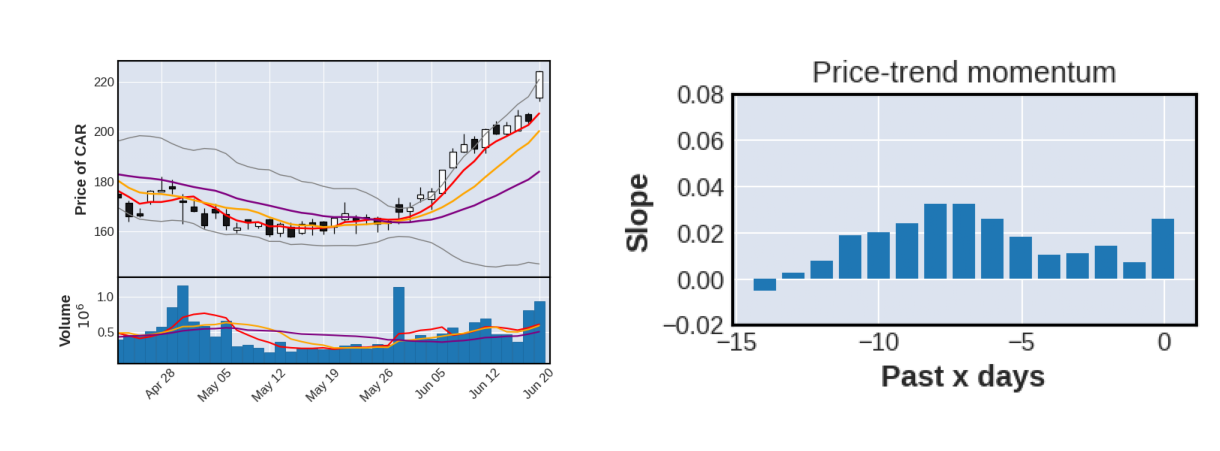

MKSI, ['10ma up', '>5ma', 'ma 5>10>20']


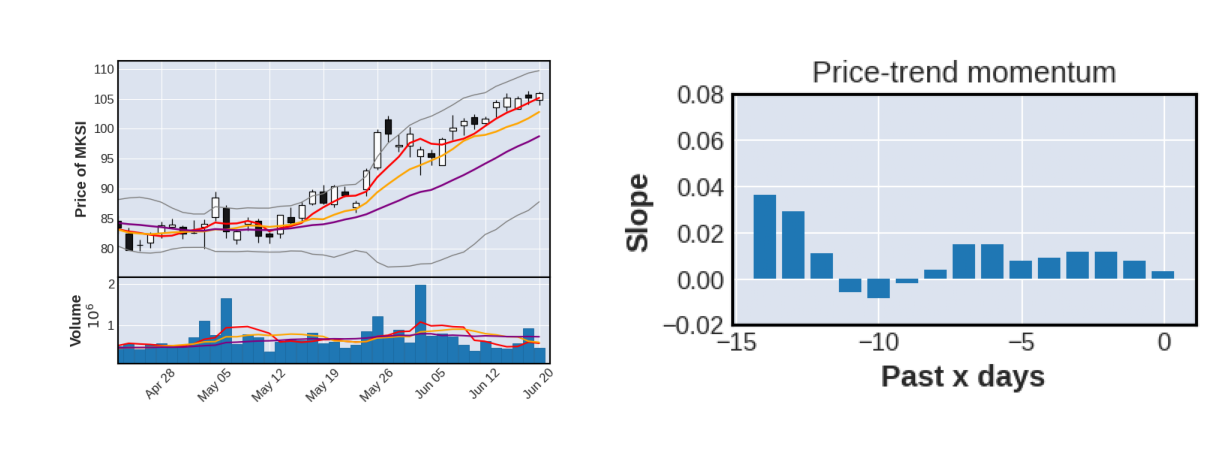

NVDA, ['10ma up', 'slope', '>5ma']


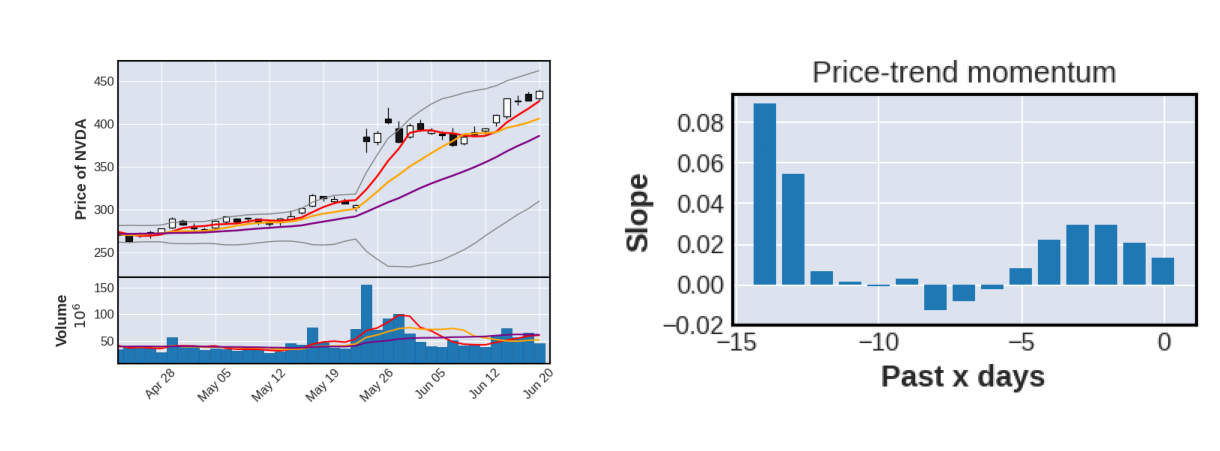

COHR, ['10ma up', 'slope', '>5ma', 'ma 5>10>20']


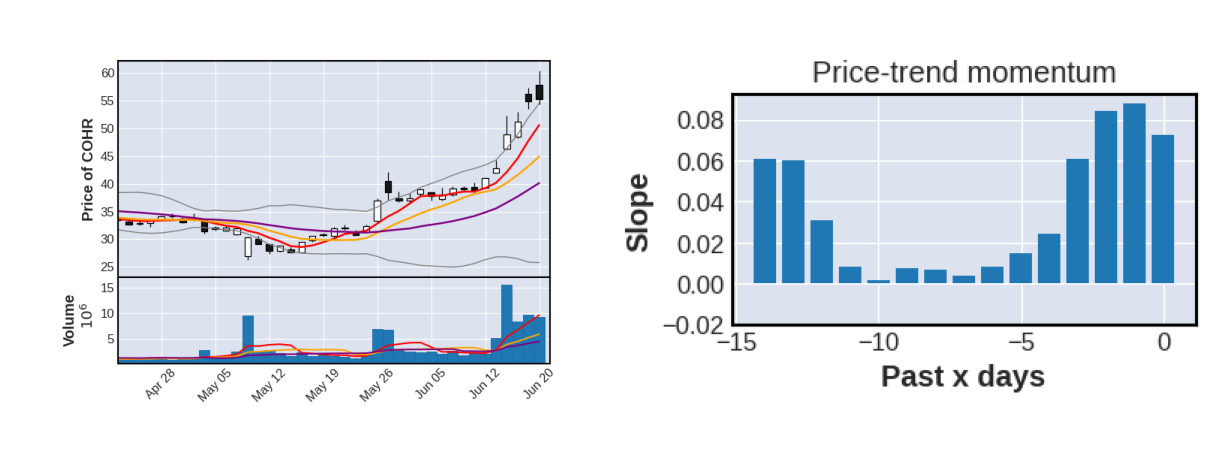

LAZ, ['slope', '>5ma', 'ma 5>10>20']


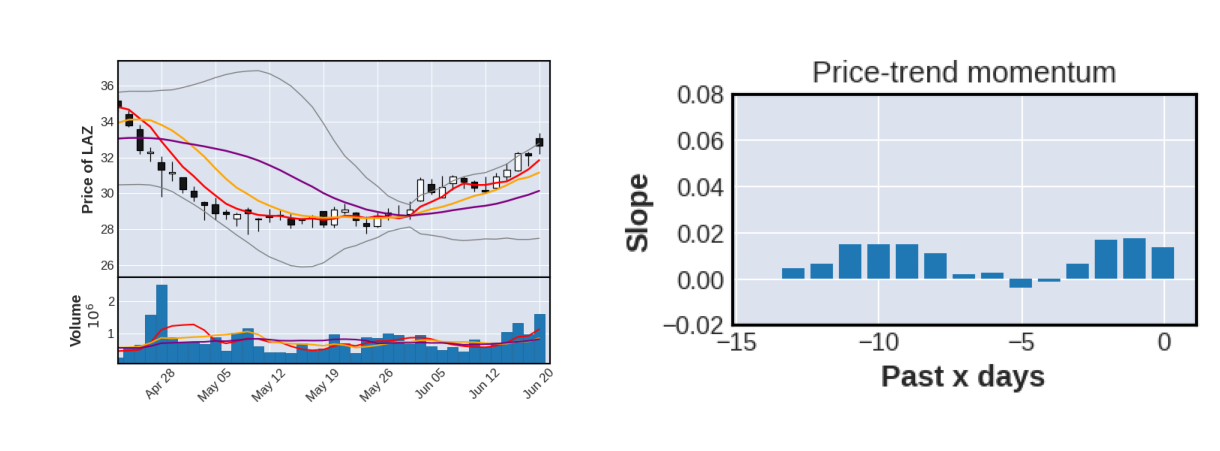

In [29]:
# For demo purpuse, only show 5
display_analysis(list(worth_analysis.keys())[:5], chosen_data, worth_analysis)